<a href="https://colab.research.google.com/github/sean-metzger/code_examples/blob/master/use_large_classificiation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install wandb
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
import io
import cv2
import albumentations as A
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader


class TiltDataset(Dataset):
    def __init__(self, im_fp, labels_fp, transform=None, indices=None, preprocess=None, label_preprocess=None):

        """
        Dataset for tilt images and masks.
        """
        import os
        self.im_files = os.listdir(im_fp)
        self.im_files = [i for i in self.im_files if '.jpg' in i]
        if indices:
            self.im_files = [self.im_files[i] for i in indices]

        self.labels = pd.read_csv(labels_fp)
        self.sites = sorted([s.replace('.jpg', '') for s in self.im_files])
        self.transform = transform

        self.preprocess_fn = preprocess
        print('preprocess fn', self.preprocess_fn)
        self.im_fp = im_fp
        self.label_preprocess = label_preprocess

    def __len__(self):
        return len(self.sites)



    def __len__(self):
        return len(self.sites)

    def preprocess(self, image, label):
        if self.preprocess_fn:
            image = self.preprocess_fn(torch.from_numpy(image).permute(-1, 0, 1))
        if self.label_preprocess:
            label = self.label_preprocess(label)
        return image, label

        if self.label_preprocess:
            label = self.label_preprocess(label)

        return image, label

    def get_label(self, im_file):

        return self.labels.loc[self.labels['EnergySiteId'] == im_file.replace('.jpg', '')].iloc[0]['PV.Module..1.Tilt']

    def __getitem__(self, idx):
        image = cv2.imread(os.path.join(self.im_fp, self.im_files[idx]))
        if image is None:
          print(self.im_files[idx])
          assert False
        image = cv2.resize(image, (224, 224))

        tilt = self.get_label(self.im_files[idx])

        image, tilt = self.preprocess(image, tilt)
        image = image.permute(1, 2, 0).numpy()
        if self.transform:
            # image, target, mask = self.transform(image, target, mask)
            # Use albumentations
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, tilt

In [3]:
n_bins = 10
max_bin = 45

In [4]:
def bin_tilt(tilt_value, num_bins=n_bins, maxval =max_bin):
  # Calculate the bin size
  bin_size = maxval / num_bins

  # Calculate the bin indices for each element in the array
  bin_indices = np.floor_divide(tilt_value, bin_size).astype(int)

  bin_indices = np.array(bin_indices)

  # Clip any out-of-range elements to fit within the bin range
  np.clip(bin_indices, -1, maxval-1, out=bin_indices)


  # Clip any out-of-range elements to fit within the bin range
  np.clip(bin_indices, 0, num_bins - 1, out=bin_indices)

  return bin_indices

In [5]:
import matplotlib.pyplot as plt
import albumentations as A
transforms = A.Compose([
    # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    A.RandomSizedCrop(min_max_height=(200, 224), width=224, height=224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5)
])
from torchvision.models import resnet50, ResNet50_Weights
model = resnet50(weights=ResNet50_Weights.DEFAULT)
weights = ResNet50_Weights.DEFAULT
preprocessing = weights.transforms()



In [6]:
tilt_dset = TiltDataset(im_fp=str(r'/content/gdrive/MyDrive/all_sites/'),
                        labels_fp=str(r'/content/gdrive/MyDrive/powerclerk_sites.csv'),
                        preprocess=preprocessing, transform=transforms)
tilt_dset.__len__()

preprocess fn ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


<ipython-input-2-8aac114a2d21>:29: DtypeWarning: Columns (2,66,67,74,75,76,83,84,85,92,182,183,187,188,192,193) have mixed types. Specify dtype option on import or set low_memory=False.
  self.labels = pd.read_csv(labels_fp)


8324

In [7]:
preprocessing

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


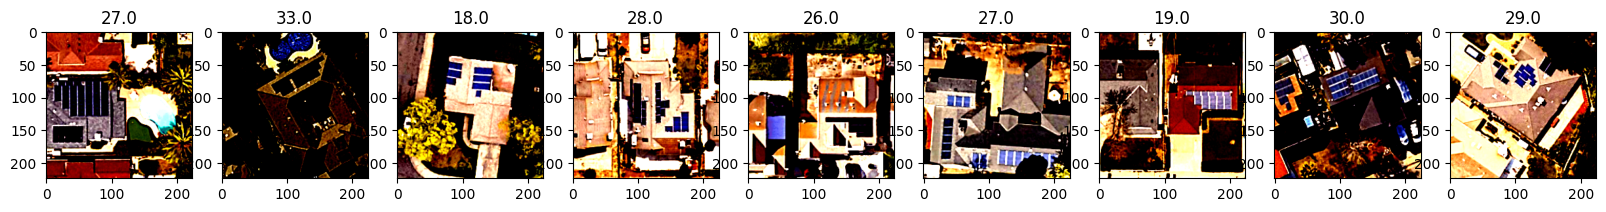

In [8]:
ct = 0
plt.figure(figsize=(20, 2))
for a, b in tilt_dset:
  plt.subplot(190+ct+1)
  plt.imshow(a[:, :, ::-1])
  plt.title(b)
  ct +=1

  if ct > 8:
    break
plt.show()

In [9]:
REGRESSION = True

if REGRESSION:
  model.fc = nn.Linear(2048, 1) # Lets start it as regression
else:
  model.fc = nn.Linear(2048, n_bins) # Lets start it as classification

device = 'cuda'

In [31]:
from tqdm import tqdm
def train_loop(model, optimizer, loader, device, REGRESSION=True):
    if REGRESSION:
        loss_fn = nn.MSELoss()
    else:
        loss_fn = nn.CrossEntropyLoss(ignore_index=-1)
    total_loss = 0
    total_samps = 0
    total_inds = 0
    acc = 0
    model.train()
    for im, target in tqdm(loader):
        im = im.float().to(device).permute(0, -1, 1, 2)
        if REGRESSION:
          target = target.float().to(device)
        else:
          target = target.long().to(device)

        optimizer.zero_grad()
        prediction = model(im)

        loss = loss_fn(prediction, target)
        loss.backward()

        if REGRESSION:
          acc += loss.item()*im.shape[0]
          total_inds += im.shape[0]

        else:
          hard_preds = F.softmax(prediction, dim=1).argmax(dim=1)
          batch_acc, total_ind = accuracy_with_ignore(hard_preds, target)
          acc += batch_acc*total_ind
          total_inds += total_ind
        optimizer.step()
        total_loss += loss.item() * im.shape[0]
        total_samps += im.shape[0]

    return total_loss/total_samps, acc/total_inds

def test_loop(model, optimizer, loader, device, REGRESSION=True):
    if REGRESSION:
        loss_fn = nn.MSELoss()
    else:
        loss_fn = nn.CrossEntropyLoss(ignore_index=-1)
    total_loss = 0
    total_loss = 0
    total_samps = 0
    total_inds = 0
    acc = 0
    model.eval()
    with torch.no_grad():
        for im, target in tqdm(loader):
            im = im.float().to(device).permute(0, -1, 1, 2)
            if REGRESSION:
              target = target.float().to(device)
            else:
              target = target.long().to(device)

            prediction = model(im)
            prediction = prediction

            loss = loss_fn(prediction, target)

            if REGRESSION:
              acc += loss.item()*im.shape[0]
              total_inds += im.shape[0]

            else:
              hard_preds = F.softmax(prediction, dim=1).argmax(dim=1)
              batch_acc, total_ind = accuracy_with_ignore(hard_preds, target)
              acc += batch_acc*total_ind
              total_inds += total_ind

            total_loss += loss.item() * im.shape[0]
            total_samps += im.shape[0]

    return total_loss/total_samps, acc/total_inds


def epoch(model, optimizer, train_loader, test_loader, device):
    tr_loss, tr_acc = train_loop(model, optimizer, train_loader, device)
    te_loss, te_acc = test_loop(model, optimizer, test_loader, device)

    wandb.log({
        'Train loss':tr_loss,
        'Test loss':te_loss,
        'Train acc':tr_acc,
        'Test acc':te_acc
    })
    print(f'Train loss: {tr_loss}, Test loss: {te_loss}')
    print(f"Train acc: {tr_acc}, test acc: {te_acc}")

    return tr_loss, te_loss

In [32]:
def plot_tilts(model, test_loader, device, num_to_plot=5, REGRESSION=True):
    model.eval()
    gts = []
    plotted = 0
    plt.figure(figsize=(2*num_to_plot, 2))
    with torch.no_grad():
        for im, target in test_loader:
            im = im.float().to(device).permute(0, -1, 1, 2)
            if REGRESSION:
              target = target.float().to(device)
            else:
              target = target.long().to(device)
            prediction = model(im)
            if not REGRESSION:
              prediction = F.softmax(prediction, dim=1).argmax(dim=1)
              prediction = prediction.detach().cpu().numpy()

            if plotted < num_to_plot:
              for im, targ, pred in zip(im, target, prediction):

                  plt.subplot(100 + (num_to_plot+1)*10 + plotted+1)
                  plt.imshow(im.cpu().permute(1, 2, 0))
                  plt.title(f'pred {pred.item():.2f}' +' ' + f'{targ}')
                  if plotted >= num_to_plot:
                    plt.show()
                    return
                  plotted +=1

In [36]:
from math import e
def eval_preds(model, test_loader, device, num_to_plot = 5, REGRESSION=True):
    model.eval()
    predictions = []
    gts = []
    plotted = 0
    with torch.no_grad():
        for im, target, in test_loader:
            im = im.float().to(device).permute(0, -1, 1, 2)
            if REGRESSION:
              target = target.float().to(device)
            else:
              target = target.long().to(device)

            prediction = model(im)
            if not REGRESSION:
              hard_preds = F.softmax(prediction, dim=1).argmax(dim=1)
              hard_preds = hard_preds.detach().cpu().numpy()
            else:
              hard_preds = prediction.detach().cpu().numpy()
            predictions.append(hard_preds)
            gts.append(target)

    return predictions, gts

def plot_distributions(model, test_loader, device, REGRESSION=True):
  p, g = eval_preds(model, test_loader, device)

  preds, gts = [], []
  for pp, gg in zip(p, g):

    gg= gg.cpu().numpy()
    gg_= gg[np.where(gg !=-1)]
    pp = pp[np.where(gg!=-1)]
    preds.extend(pp)
    gts.extend(gg_)

  preds, gts = np.array(preds), np.array(gts)
  plt.figure(figsize=(9, 3))
  plt.subplot(131)
  plt.scatter(preds, gts)
  plt.xlim([0, 45])
  plt.ylim([0, 45])
  plt.subplot(132)
  plt.xlim([0, 45])
  plt.hist(preds, bins=10)
  plt.title('Predictions')
  plt.subplot(133)
  plt.hist(gts, bins=10)
  plt.xlim([0, 45])
  plt.title('GTs')
  plt.show()



def plot_cm(model, test_loader, device):
  p, g = eval_preds(model, test_loader, 'cuda', REGRESSION=False)
  preds, gts = [], []
  for pp, gg in zip(p, g):

    gg= gg.cpu().numpy()
    gg_= gg[np.where(gg !=-1)]
    pp = pp[np.where(gg!=-1)]
    preds.extend(pp)
    gts.extend(gg_)

  print('This acc: %.2f' % (np.mean(np.array(preds) == np.array(gts))))
  from sklearn.metrics import confusion_matrix
  cm = confusion_matrix(np.array(gts), np.array(preds), normalize='true')
  sns.heatmap(cm)
  plt.show()
  error = (np.array(gts)*max_bin/n_bins - np.array(preds)*max_bin/n_bins)
  print('Mean abs error', np.abs(error).mean(), 'Median abs error', np.median(np.abs(error)))
  print('MSE', np.square(np.abs(error)).mean())

  # Get the most common category
  from collections import Counter
  c = Counter(np.array(gts))
  most_common = c.most_common(1)[0][0]
  print('Chance', np.mean(np.array(gts) == most_common))
  chance_err = (np.array(gts)*max_bin/n_bins-most_common*max_bin/n_bins)
  print('Chance error', np.square(np.abs(chance_err)).mean())


In [37]:
!pip install wandb
import wandb

<ipython-input-2-8aac114a2d21>:29: DtypeWarning: Columns (2,66,67,74,75,76,83,84,85,92,182,183,187,188,192,193) have mixed types. Specify dtype option on import or set low_memory=False.
  self.labels = pd.read_csv(labels_fp)


preprocess fn ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
preprocess fn ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


<ipython-input-2-8aac114a2d21>:29: DtypeWarning: Columns (2,66,67,74,75,76,83,84,85,92,182,183,187,188,192,193) have mixed types. Specify dtype option on import or set low_memory=False.
  self.labels = pd.read_csv(labels_fp)


Epoch 0


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


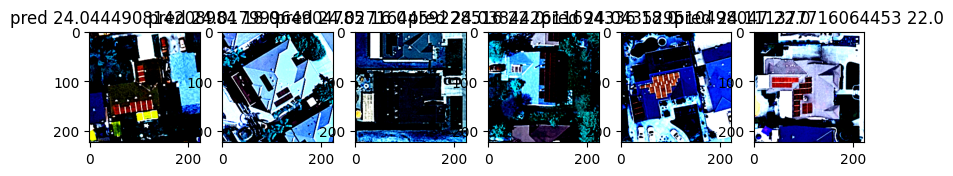

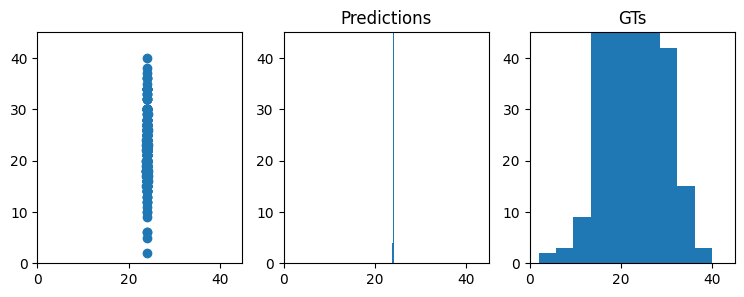

----------------------------------------------------------------------------------------------------
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10


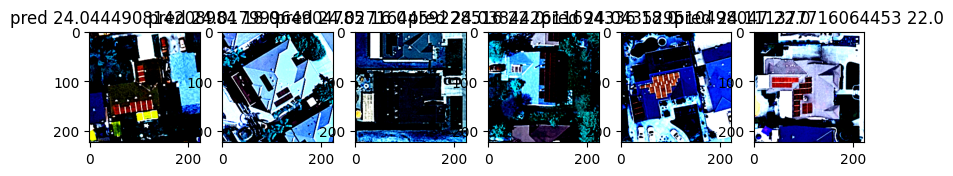

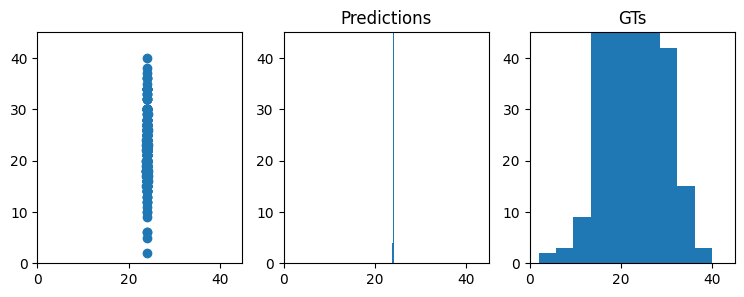

----------------------------------------------------------------------------------------------------
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20


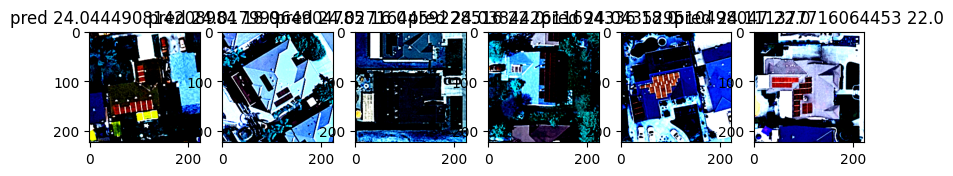

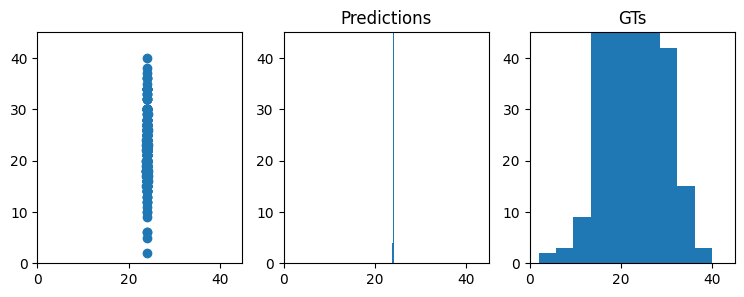

----------------------------------------------------------------------------------------------------
Epoch 21


In [38]:
cutoff = int(.9*tilt_dset.__len__())

train_dset = TiltDataset(im_fp=str(r'/content/gdrive/MyDrive/all_sites/'),
                        labels_fp=str(r'/content/gdrive/MyDrive/powerclerk_sites.csv'), indices=list(np.arange(cutoff)),
                        preprocess=preprocessing, transform=transforms) # TiltDataset(str(r'/content/gdrive/MyDrive/dataset'), , preprocess=preprocess_input, transform=transforms)
test_dset = TiltDataset(im_fp=str(r'/content/gdrive/MyDrive/all_sites/'),
                        labels_fp=str(r'/content/gdrive/MyDrive/powerclerk_sites.csv'), indices=list(np.arange(cutoff, tilt_dset.__len__())),
                        preprocess=preprocessing, transform=None) #TiltDataset(str(r'/content/gdrive/MyDrive/dataset'), indices=list(np.arange(cutoff, tilt_dset.__len__())), preprocess=preprocess_input, transform=None)

train_loader = DataLoader(train_dset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dset, batch_size=64, shuffle=False)

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
patience = 20
n_epochs = 1000
best_loss = 1e9
patience_ctr = 0
best_acc = 0

import wandb
wandb.init(project='tilt_directestimate',
           config={'n_bins': n_bins, 'max_bin': max_bin, 'regression':REGRESSION,
                   'balanced':False})

import copy
for epochct in range(n_epochs):
    print(f'Epoch {epochct}')
    # trl, tel = epoch(model, optimizer, train_loader, test_loader, device)
    if tel < best_loss:
      best_loss=  tel
      patience_ctr = 0
      best_model = copy.deepcopy(model)
    else:
      patience_ctr +=1
    if patience_ctr > patience:
      break

    if epochct % 10 == 0:
      plot_tilts(best_model, test_loader, device, num_to_plot=5, REGRESSION=REGRESSION)
      if not REGRESSION:
        plot_cm(best_model, test_loader, device)
      else:
        plot_distributions(best_model, test_loader, device)
      print('-'*100)




